# Formation Flying and Landing
## (Corresponding to Chapter 11)

### Notebook Initialization

In [1]:
# Numeric and symbolic libraries
import sympy as sym
import numpy as np
sym.init_printing()

# Plot libraries for main plots
from matplotlib.pyplot import subplots, rcParams
__colors = rcParams['axes.prop_cycle'].by_key()['color']
def get_color(index):
    return __colors[index%10]

# Plot libraries for animations
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
# Load single-agent models
%run models.ipynb
from systemsim.mechanical import SymbolicIDAPBCAgent
from systemsim.network import DistributedIDAPBC

## Single-agent Model and IDA-PBC

In [3]:
# Load UAV Model
model = planar_uav()

k1val = 2
eps = 0.1

parameters = {
    # Model and environment
    'g': 9.81, 'epsilon': eps,
    # Control parameters
    'k_1': k1val, 'k_2': 1/(1.5*eps), 'k_3': (5+0.1)*k1val*eps, 
    # Damping 
    'K_v1': 1*0, 'K_v2': 20*0, 'K_d1': 2, 'K_d2': 2,
    # Animation size
    'base': 0.2
}

# Network Simulation (Formation Flying)

In [4]:
from numpy.random import random, seed

# Number of UAVs
N = 6

# Pseudo random initial conditions generator
def randvec():
    return random(3)-0.5

# Choose to simulate either with agents approximately upright or upside down
upsidedown_init = False

# Choose to use undirected graph or directed graph
undirected_graph = True

# Depending on selection, initialize the agents
if not upsidedown_init:
    seed(2) 
    uavs = [SymbolicIDAPBCAgent(model, parameters, randvec()*2+np.array([0,2,0]), randvec()) for i in range(N)]
else:
    seed(1)
    uavs = [SymbolicIDAPBCAgent(model, parameters, randvec()*2+np.array([0,3,np.pi]), randvec()) for i in range(N)]
    
# The undirected graph is as follows:
#              4
#             / \
#            /   \
#           1     2
#          / \   / \
#         /   \ /   \
#        6-----3-----5
#
# Length of the edges
d = 1
# Height of triangle
h = np.sin(np.pi/3)*d

# Ajacency gains
adjacency = np.diag([1,2])

# Make the graph as a set of directed edges
directed_edges = {
    (uavs[1-1], uavs[2-1]): (adjacency, np.array([d,0])),
    (uavs[6-1], uavs[3-1]): (adjacency, np.array([d,0])),
    (uavs[3-1], uavs[5-1]): (adjacency, np.array([d,0])),
    (uavs[3-1], uavs[1-1]): (adjacency, np.array([-d/2,h])),
    (uavs[5-1], uavs[2-1]): (adjacency, np.array([-d/2,h])),
    (uavs[2-1], uavs[4-1]): (adjacency, np.array([-d/2,h])),
    (uavs[2-1], uavs[3-1]): (adjacency, np.array([-d/2,-h])),
    (uavs[4-1], uavs[1-1]): (adjacency, np.array([-d/2,-h])),
    (uavs[1-1], uavs[6-1]): (adjacency, np.array([-d/2,-h])),          
}
# Copy each edge and reverse the copies to obtain the undirected graph, if specified
if undirected_graph:
    weighted_edges = DistributedIDAPBC.undirected_edges(directed_edges)
else:
    weighted_edges = directed_edges

# Choose the agents on the middle row as altitude leaders
leaders = {
    uavs[1-1]: (np.array([[0, 0],[0, 5]]), np.array([0.0, 2])),
    uavs[2-1]: (np.array([[0, 0],[0, 5]]), np.array([0.0, 2]))
}            
            
# Initialize the network
network = DistributedIDAPBC(uavs, weighted_edges, leaders)

# Simulation time
time_range = np.arange(start=0,step=0.05,stop=15)

# Run simulation and show results
network.simulate(time_range)  

In [5]:
network.make_animation_data(1, 25)
animationfigure = network.get_animation_figure([-1,1],[0,3],'UAV Formation Flying (Animation of Figure 15/16/26)')
iplot(animationfigure)

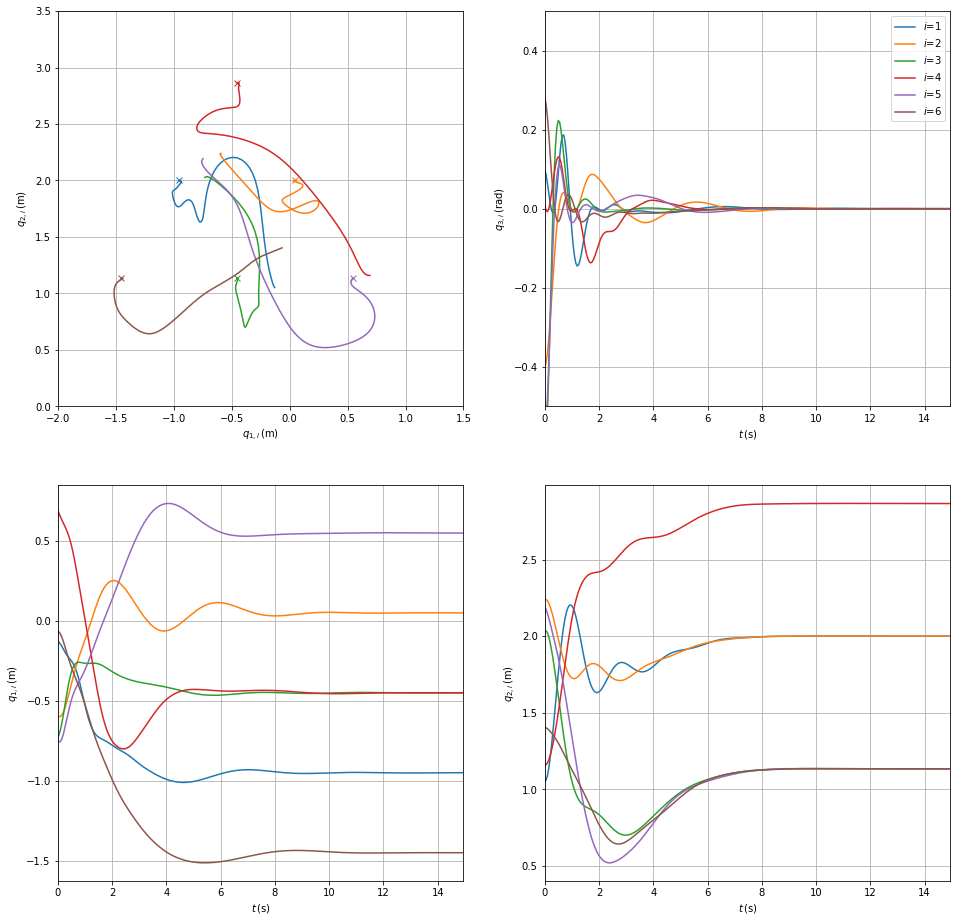

In [6]:
figure, ((travel, angles),(hor, vert)) = subplots(nrows=2, ncols=2, figsize=(16, 16))

# Travel plots
for i, uav in enumerate(uavs):
    # Extract trajectories for this UAV
    q1, q2, q3 = [uav.state_trajectory[q,:] for q in [0,1,2]]

    # Line color and name
    color = get_color(i)
    label='$i$='+str(i+1)
    
    # Draw the trajectory and end markers
    travel.plot(q1,q2, color=color, label=label)
    travel.plot(q1[-1],q2[-1], color=color, marker='x')

    # Draw the angle plot against time
    angles.plot(time_range, q3, color=color, label=label)   
    
    
    # Draw horizontal and vertical
    hor.plot(time_range, q1, color=color, label=label)
    vert.plot(time_range, q2, color=color, label=label)
    
# Travel and angle axis limits  
t_end = time_range[-1]
hor.set_xlim([0, t_end])
vert.set_xlim([0, t_end])
angles.set_xlim([0, t_end])
if not upsidedown_init:
    travel.set_xlim([-2, 1.5])
    travel.set_ylim([0, 3.5])
    angles.set_ylim([-0.5, 0.5])
else:
    travel.set_xlim([-2, 2])
    travel.set_ylim([0, 4])
    angles.set_ylim([-0.5, 0.5+np.pi*2])
    
# Grids
for ax in [travel, angles, hor, vert]:
    ax.grid(True)

# Legends and labels
travel.set_xlabel('$q_{1,i}\,$(m)')
travel.set_ylabel('$q_{2,i}\,$(m)')
hor.set_ylabel('$q_{1,i}\,$(m)')
vert.set_ylabel('$q_{2,i}\,$(m)')
angles.set_xlabel('$t\,$(s)')
hor.set_xlabel('$t\,$(s)')
vert.set_xlabel('$t\,$(s)')
angles.set_ylabel('$q_{3,i}\,$(rad)')
angles.legend()

# Controlled Synchronous Landing

In [7]:
# Load car model
model_car = car()

# Initial conditions
q_initial_car = np.array([-1])
p_initial_car = np.array([0])

parameters_car = {  
    'Kv': 2500,
    'size': 3,
    'm': 50,
    'md': 2500,
}

# Simulation time
time_range = np.arange(start=0,step=0.01,stop=10)

#### Network simulation (pre-landing)

In [8]:
N_landing = 3
seed(5)
pre_landers = [SymbolicIDAPBCAgent(model, parameters, randvec()*2+np.array([0,2,0]), randvec()) for i in range(N_landing)]

# Initialize the model
car_pre_landing = SymbolicIDAPBCAgent(model_car, parameters_car, q_initial_car, p_initial_car)

adjacency_lander = np.diag([1,2])
relative_lander = np.array([1, 0])

adjacency_car = np.array([[0.1, 0],[0, 0]])*4
relative_car = np.array([0, 0])

# Create a string of connections between the vehicles
middle_pre_lander = pre_landers[N_landing//2]     
weighted_edges_pre_landing = {}
weighted_edges_pre_landing[(middle_pre_lander, car_pre_landing)] = (adjacency_car, relative_car)
weighted_edges_pre_landing[(car_pre_landing, middle_pre_lander)] = (adjacency_car, -relative_car)
      
for i in range(N_landing-1):
    weighted_edges_pre_landing[(pre_landers[i],pre_landers[i+1])] = (adjacency_lander,  relative_lander)
    weighted_edges_pre_landing[(pre_landers[i+1],pre_landers[i])] = (adjacency_lander, -relative_lander)

      
# Initialize the network
network_prelanding = DistributedIDAPBC([car_pre_landing, *pre_landers], weighted_edges_pre_landing, leaders={})
time_pre_landing = np.arange(start=0,step=0.05,stop=6)

# Run simulation and show results
network_prelanding.simulate(time_pre_landing)
x_end = network_prelanding.x_end

In [9]:
network_prelanding.make_animation_data(0.5, 25)
animationfigure_prelanding = network_prelanding.get_animation_figure([-1,1],[-0.5,3],'UAV Landing Preparation (Animation of Figure 18, 0 < t < 6)')
iplot(animationfigure_prelanding)

In [10]:
landers = [SymbolicIDAPBCAgent(model, parameters, np.array([0,0,0]), np.array([0,0,0])) for i in range(N_landing)]
leaders_landing = {lander: (np.array([[0, 0],[0, 1]]), np.array([0, 0])) for lander in landers}
car_landing = SymbolicIDAPBCAgent(model_car, parameters_car, q_initial_car*0, p_initial_car*0)

# Create a string of connections between the vehicles
middle_lander = landers[N_landing//2]      
weighted_edges_landing = {}
weighted_edges_landing[(middle_lander, car_landing)] = (adjacency_car, relative_car)
weighted_edges_landing[(car_landing, middle_lander)] = (adjacency_car, -relative_car)
      
for i in range(N_landing-1):
    weighted_edges_landing[(landers[i],landers[i+1])] = (adjacency_lander,  relative_lander)
    weighted_edges_landing[(landers[i+1],landers[i])] = (adjacency_lander, -relative_lander)


# Initialize the network
network_landing = DistributedIDAPBC([car_landing, *landers], weighted_edges_landing, leaders_landing)
network_landing.x_initial = x_end
time_landing = np.arange(start=0,step=0.05,stop=9)

# Run simulation and show results
network_landing.simulate(time_landing)

network_landing.make_animation_data(0.5, 25)
animationfigure_landing = network_landing.get_animation_figure([-1,1],[-0.5,1],'UAV Landing  (Animation of Figure 18, t > 6)')
iplot(animationfigure_landing)


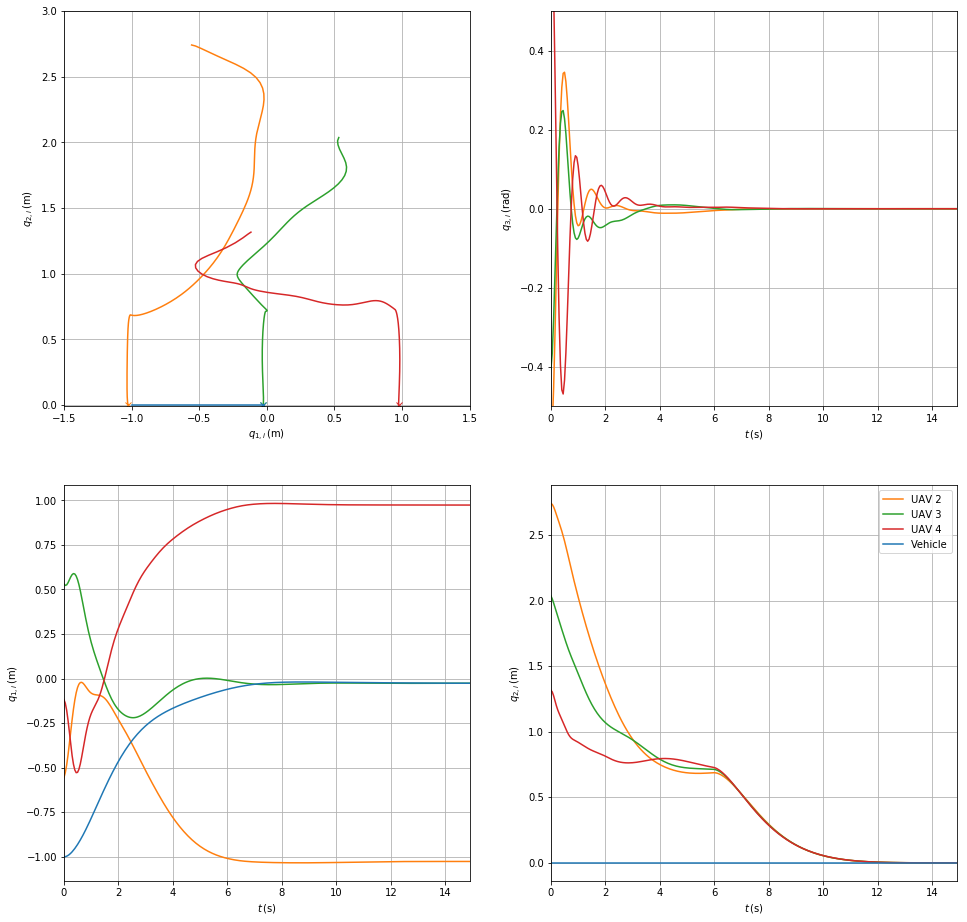

In [11]:
figure, ((travel, angles),(hor, vert)) = subplots(nrows=2, ncols=2, figsize=(16, 16))

# Travel plots
for i, lander in enumerate(landers):
    # Extract trajectories for this UAV
    q1_pre, q2_pre, q3_pre = [pre_landers[i].state_trajectory[q,:] for q in [0,1,2]]
    q1_post, q2_post, q3_post = [landers[i].state_trajectory[q,:] for q in [0,1,2]]

    q1 = np.append(q1_pre, q1_post)
    q2 = np.append(q2_pre, q2_post)
    q3 = np.append(q3_pre, q3_post)
    time_range = np.append(time_pre_landing, time_landing+time_pre_landing[-1])
    
    # Line color and name
    color = get_color(i+1)
    label='UAV '+str(i+2)
    
    # Draw the trajectory and end markers
    travel.plot(q1,q2, color=color, label=label)
    travel.plot(q1[-1],q2[-1], color=color, marker='x')

    # Draw the angle plot against time
    angles.plot(time_range, q3, color=color, label=label)   
    
    # Draw horizontal and vertical
    hor.plot(time_range, q1, color=color, label=label)
    vert.plot(time_range, q2, color=color, label=label)

# Plot the car trajectories in the relevant plots
carpath = np.append(car_pre_landing.state_trajectory[0,:],car_landing.state_trajectory[0,:])
travel.plot(carpath,carpath*0, color=get_color(0), label='Vehicle')    
travel.plot(carpath[-1],0, color=get_color(0), marker='x')
hor.plot(time_range, carpath, color=get_color(0), label='Vehicle')
vert.plot(time_range, carpath*0, color=get_color(0), label='Vehicle')
    
# Grids    
for ax in [travel, angles, hor, vert]:
    ax.grid(True)    
    
# Travel and angle axis limits    
travel.set_xlim([-1.5, 1.5])
travel.set_ylim([-0.01, 3])
t_end = time_range[-1]
hor.set_xlim([time_range[0], t_end])
vert.set_xlim([time_range[0], t_end])
angles.set_xlim([time_range[0], t_end])
angles.set_ylim([-0.5, 0.5])

# Legends and labels
travel.set_xlabel('$q_{1,i}\,$(m)')
travel.set_ylabel('$q_{2,i}\,$(m)')
hor.set_ylabel('$q_{1,i}\,$(m)')
vert.set_ylabel('$q_{2,i}\,$(m)')
angles.set_xlabel('$t\,$(s)')
hor.set_xlabel('$t\,$(s)')
vert.set_xlabel('$t\,$(s)')
angles.set_ylabel('$q_{3,i}\,$(rad)')
vert.legend()